In [15]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed

from echo_state_network import ESN

Equation for the first pendulum: $mL\ddot{\theta_{1}} = -gmsin(\theta_{1}) - kLsin(\theta_{1} - \theta_{2})$

Equation for the second pendulum: $mL\ddot{\theta_{2}} = -gmsin(\theta_{2}) + kLsin(\theta_{1} - \theta_{2})$

# Equation independent of the second angle to get started

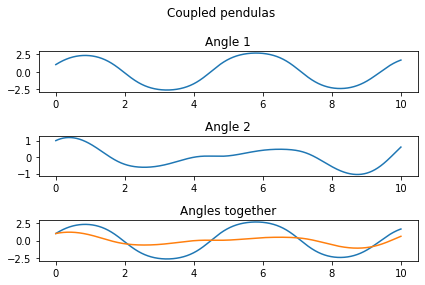

In [16]:
L_1 = 3
g_1 = 9.81
k_1 = 2
m_1 = 2

def coupled_pendulum(w, t, p):
    # x_i = theta_i
    # y_i = theta_i'
    # Return [theta1', theta1'', theta2', theta2'']
    # In our terminology: [y1, y1', y2, y2']
    
    x1, y1, x2, y2 = w
    g, L, k, m = p
    
    theta1_double_prime = - g/L * np.sin(x1) - k/m * np.sin(x1 - x2) # Phase difference
    theta2_double_prime = - g/L * np.sin(x2) - k/m * np.sin(x2 - x1) # Phase difference, but adjusted for -
    
    return [y1, theta1_double_prime, y2, theta2_double_prime]


def compute_L2(data1, data2):
    return ((data1 - data2) ** 2).sum()


def getESN(input_channels, n_reservoir, spectral_radius, sparsity, noise, teacher_forcing):
    return ESN(
        input_channels, 
        1, 
        n_reservoir=n_reservoir,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        noise=noise, 
        input_shift=None,
        input_scaling=1/10, 
        teacher_forcing=teacher_forcing, 
        feedback_scaling=None,
        teacher_scaling=None, 
        teacher_shift=0.001,
        out_activation=lambda x: x, #tanh, sigmoid
        inverse_out_activation=lambda x: x, #TODO ?
        random_state=None, 
        silent=False
    )

t = np.linspace(0, 10, num=10000)

# Pack up the parameters and initial conditions:
p = [g_1, L_1, k_1, m_1]

#Initial values
w0 = [1, 3, 1, 1]

abserr = 1.0e-8
relerr = 1.0e-6

# Call the ODE solver.
solution = odeint(coupled_pendulum, w0, t, args=(p,), atol=abserr, rtol=relerr)
angle1 = solution[:, 0]
angle2 = solution[:, 2]

fig, axs = plt.subplots(3)
fig.suptitle('Coupled pendulas')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
axs[2].set_title('Angles together')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)
axs[2].plot(t, angle1, t, angle2)

## Predictions on the first angle using ESN, numerical solution

harvesting states...
fitting...
training error:
0.013601882779675062


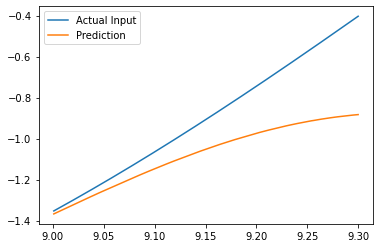

In [17]:
esn = getESN(1, 1000, 0.5, 0.2, 0, False)

cutoff = int(len(t) * 0.9)

t_train = t[:cutoff]
y_train = angle1[:cutoff]

t_test = t[cutoff:]
y_test = angle1[cutoff:]

weights = esn.fit(t_train, y_train)

N = 300

pred = esn.predict(t_test[:N])[:, 0]

plt.plot(t_test[:N], y_test[:N], t_test[:N], pred)
plt.legend(['Actual Input', 'Prediction'])

# errs = []

# for i in range(1, 121):
#     pred = esn.predict(t_test[:i])[:, 0]
    
#     print('INDEX:', i)
    
#     errs.append(((pred - y_test[:i]) ** 2).mean())
    
# plt.plot(list(range(1, 121)), errs)

# Prediction with second angle as input

harvesting states...
fitting...
training error:
0.00010860846096209133


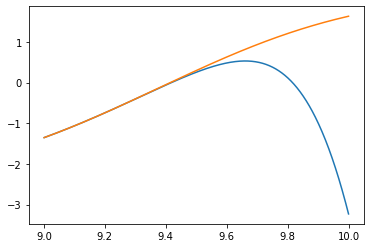

In [25]:
training_data_input = np.column_stack((t[:cutoff], angle2[:cutoff]))
training_data_output = angle1[:cutoff]

validation_data_input = np.column_stack((t[cutoff:], angle2[cutoff:]))
validation_data_output = angle1[cutoff:]

esn = getESN(2, 1000, 0.5, 0.2, 0, False)

weights = esn.fit(training_data_input, training_data_output)

pred = esn.predict(validation_data_input)

plt.plot(validation_data_input[:,0], pred, validation_data_input[:, 0], validation_data_output)

# Adding second angle as input channel

In [14]:
esn = getESN(2, 3000, 0.9, 0.2, 0, False)

# N training samples X 2 [time, angle2]
# N training samples X 1 (angle 1)

cutoff = int(len(t) * 0.93)
training_data_input = np.column_stack((t[:cutoff], angle2[:cutoff]))
training_data_output = angle1[:cutoff]

validation_data_input = np.column_stack((t[cutoff:], angle2[cutoff:]))
validation_data_output = angle1[cutoff:]

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]
# TODO fix this thing
plt.plot(t[:cutoff], prediction, t[:cutoff], angle1[:cutoff])

KeyboardInterrupt: 

# Analytic approximation

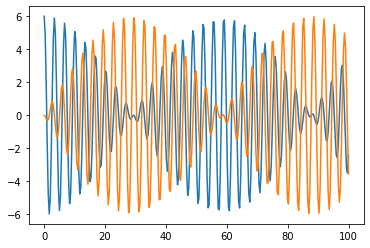

In [142]:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_Mechanics_and_Relativity_(Idema)/08%3A_Oscillations/8.04%3A_Coupled_Oscillators
def compute_angles(time, initial_angle, k, g, l):
    omega_prime = np.sqrt(2 * k + g/l)
    omega_0 = np.sqrt(g/l)
    inner_term_1 = ((omega_0 + omega_prime) / 2) * t 
    inner_term_2 = ((omega_0 - omega_prime) / 2) * t
    
    angle1 = initial_angle * np.cos(inner_term_1) * np.cos(inner_term_2)
    angle2 = initial_angle * np.sin(inner_term_1) * np.sin(inner_term_2)
    
    return angle1, angle2

t = np.linspace(0, 100, 300)
initial_angle = 6
k = 0.2
g = 9.81
l = 3

angle1, angle2 = compute_angles(t, initial_angle, k, g, l)

plt.plot(t, angle1, t, angle2)

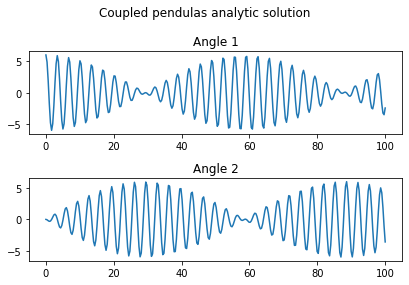

In [143]:
fig, axs = plt.subplots(2)
fig.suptitle('Coupled pendulas analytic solution')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)

# Predicting Angle 1 of coupled pendulum analytical solution with small angle approximation

harvesting states...
fitting...
training error:
2.606965194083856
L^2 error 2220240.121911047


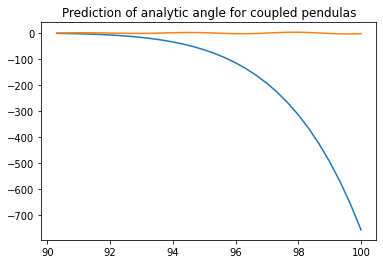

In [144]:
esn = getESN(1, 600, 0.2, 0.1, 0, False)

cutoff = int(len(t) * 0.9)

training_data_output = angle1[:cutoff]
training_data_input = t[:cutoff]

validation_data_output = angle1[cutoff:]
validation_data_input = t[cutoff:]

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(validation_data_input, prediction, validation_data_input, validation_data_output)
plt.title('Prediction of analytic angle for coupled pendulas')

print('L^2 error', compute_L2(validation_data_output, prediction))

# Introducing 2nd channel, the angle of the 2nd pendulum

harvesting states...
fitting...
training error:
0.20678164261172358


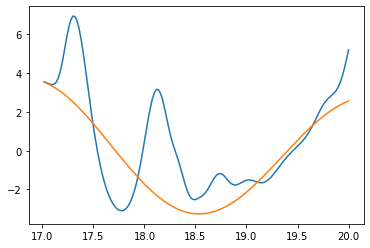

In [126]:
esn = getESN(2, 1000, 1, 0.3, 0, False)

angle_training_input = angle2[:cutoff]
time_training_input = t[:cutoff]

angle_validation_input = angle2[cutoff:]
time_validation_input = t[cutoff:]

training_data_input = np.column_stack((time_training_input, angle_training_input))
validation_data_input = np.column_stack((time_validation_input, angle_validation_input))

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(time_validation_input, prediction, time_validation_input, validation_data_output)